## AB test
[A/B test](https://towardsdatascience.com/data-science-you-need-to-know-a-b-testing-f2f12aff619a) (also known as a randomised controlled trial, or RCT, in the other sciences. An A/B test will enable us to accurately quantify our effect size and errors, and so calculate the probability that we have made a type I or type II error.

I would argue that only once we understand the true effect size and robustness of our results, can we proceed to making business-impact decisions. To phrase this another way, we should only estimate the ROI (return on investment) of a new product once we understand our effect size and errors.

## PYMC3 tutorial

Article -> https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd

Experiment -> 10% of users, then split 50:50 and show each half a different image, which to the users click on? It's common practice to choose a minimum confidence value to call a winner. That is subject to lots of factors but in most cases a significance level of 5% is used, which translates to a confidence value of 2.5% and 97.5%.

In [1]:
%matplotlib inline
import pymc3 as pm
import seaborn as sb
from theano import config
config.warn.round=False

n = 1000
obs_v1 = 680
obs_v2 = 700

with pm.Model() as model: # context management
    # define priors
    prior_v1 = pm.Beta('prior_v1', alpha=2, beta=2)
    prior_v2 = pm.Beta('prior_v2', alpha=2, beta=2)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n, p=prior_v1, observed=obs_v1)
    like_v2 = pm.Binomial('like_v2', n=n, p=prior_v2, observed=obs_v2)
    
    # define metrics
    pm.Deterministic('difference', prior_v2 - prior_v1)
    pm.Deterministic('relation', (prior_v2/prior_v1) - 1)

    # inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

/Users/robincole/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '47737' (I am process '31563')
/Users/robincole/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -154.95, ||grad|| = 269.07: 100%|██████████| 7/7 [00:00<00:00, 42.53it/s]   
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [prior_v2]
>M

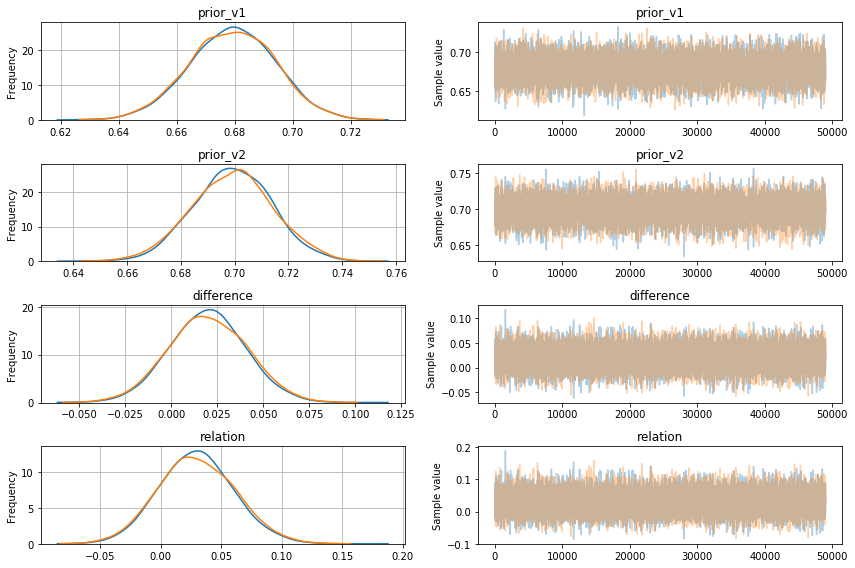

In [2]:
_ = pm.traceplot(trace[1000:], grid=True)

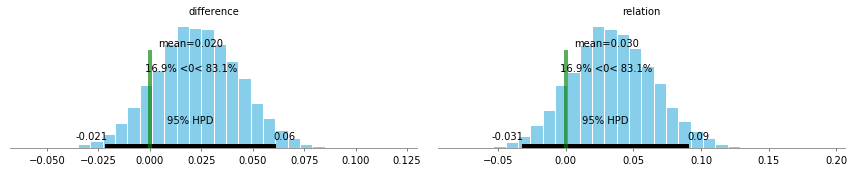

In [3]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

Looking at the difference or relation histogram we see we have 83% confidence that variation 2 is better than variation 1. If we have earlier defined a significance level of 5%, we can't declare a winner yet. We need to either capture more data or stop the experiment and call it a draw.